# COVID-19 and Temperature

As we approach the summer months, how might the rate of COVID-19 infections in humans increase or decrease? I aim to find a correlation between the infection rate and the temperature. To accomplish this, I will gather data about various US counties' monthly:

- Total number of infections
- Total number of deaths
- Average temperature
- Population Density

I wanted to drill in the data down to the county and month in order to leave out rooms for error such as the different temperatures per month and the varied temperatures between counties. This level of specificity should be fairly sufficient since counties generally have the same temperature due to small variations in latitude, longitude, and biomes between them. I also elected to choose the United States only because of the varied temperatures and biomes it has, and also the US had widespread testing insufficiencies. If I included other countries, that would skew the data.

### Datasets

USAFacts Google COVID Infections Dataset: https://console.cloud.google.com/marketplace/details/bigquery-public-datasets/covid19-dataset-list?filter=solution-type:dataset&filter=category:covid19&id=4a850823-3f83-48f5-92d1-01ba6f8ed81e

```SELECT * FROM `bigquery-public-data.covid19_usafacts.confirmed_cases```

```SELECT * FROM `bigquery-public-data.covid19_usafacts.deaths```

Wunderground weather: https://www.wunderground.com/history

Populations: https://api.census.gov/data/2019/pep/population?get=POP&for=county:*&in=state:*&key=

### Is this a reasonable task?

Originally, I had thought that merely aggregating daily average temperature data for various counties and obtaining the total number of infections corresponding to those temperatures was sufficient. Then, I thought it would be good to input the temperature and output the infections to predict the number of infections based on the temperature; however, after plotting this data, it became apparent that the two were not correlated or linear. Thus, after consultation, I obtained advice to make more use of the data by changing the scope of my project to take into account the population size in the form of a normalized data point, the transmission rate. After adjusting my project, I think this is a reasonable task.

### What are its input and output?

Its input will take in the sample average and variance and output the infection rate.

### Model effectiveness

Initially, I created an SVM model for the current data. I don't think it is a good fit so far because I did not yet apply the suggested changes to the model; it does not provide meaningful predictions. I obtained the deaths, population, temperature and infections and will apply the normalized data next.


In [1]:
import pandas
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [2]:
# Clean up infections data

def clean_infections():
    covid_data = pandas.read_csv('./confirmed-usafacts.csv')

    # Remove FIPS Code & January
    covid_data.drop(covid_data.columns[3:14], axis=1, inplace=True)

    # Remove May
    covid_data.drop(covid_data.columns[93:], axis=1, inplace=True)

    # Remove unneeded cities
    covid_data.drop(covid_data.index[108:], inplace=True)

    # Counties with no temperature data - remove
    drop = [13,18,21,26,32,33,35,36,37,38,39,42,43,44,45,46,47,50,58,59,60,61,62,66,69,70,71,73,74,78,82,84,85,86,87,88,89,93,94,97,98,106]

    for i in reversed(range(len(drop))):
        covid_data.drop(covid_data.index[drop[i]], inplace=True)

    # Save
    covid_data.to_csv('./covid-clean.csv')

In [3]:
# Clean up deaths data

def clean_deaths():
    deaths_data = pandas.read_csv('./covid-clean-deaths.csv')

    # Remove FIPS Code & January
    deaths_data.drop(deaths_data.columns[4:15], axis=1, inplace=True)

    # Remove May
    deaths_data.drop(deaths_data.columns[94:], axis=1, inplace=True)

    # Save
    deaths_data.to_csv('./covid-clean-deaths.csv', index=False)

In [4]:
# Remove Feb 29

def clean_temperature():
    temperature = pandas.read_csv('./covid-temperature.csv')

    temperature.drop(temperature.columns[32], axis=1, inplace=True)

    temperature.to_csv('./covid-temperature.csv', index=False)

In [5]:
# Sort deaths to match indices of infections

def match_dataset_indices():
    covid_data = pandas.read_csv('./covid-clean.csv')
    deaths_data = pandas.read_csv('./covid-clean-deaths.csv')
    d_data = pandas.read_csv('./covid-cleaner-deaths.csv')

    deaths = []

    for i in range(0, len(covid_data) - 1):
        for j in range(0, len(deaths_data) - 1):
            if covid_data.values[i][1] == deaths_data.values[j][0]:
                deaths.append(deaths_data.values[j])

    for i in deaths:
        d_data.loc[len(d_data)] = i

    d_data.to_csv('./covid-cleaner-deaths.csv')


In [6]:
# Accumulate infections for each temperature (old idea)

infections = pandas.read_csv('./covid-clean.csv')
temperature = pandas.read_csv('./covid-temperature.csv')

temp_infections = {}

for i in range(0,65):
    for j in range(4,93):
        temp_infections[float(temperature.values[i][j])] = temp_infections.get(float(temperature.values[i][j]), 0) + float(infections.values[i][j])

In [7]:
# Accumulate # infections for each temperature & store (old idea)

import math

# Store values

df = pandas.DataFrame([[items[0], items[1]] for items in temp_infections.items() if not math.isnan(items[0])], columns=['temperature', 'infections'])

df.to_csv('temp-vs-infections.csv', index=False)

In [8]:
# Get populations data

def get_population_data():
    cc = pandas.read_csv('./covid-clean.csv')

    p = []

    for i in range(0, len(cc.values)):
        for j in range(0, len(populations)):
            if (str(cc.values[i][1]) == str(int(populations[j][1] + populations[j][2]))):
                p.append([cc.values[i][1], cc.values[i][2], populations[j][0]])

def write_population_data():
    pop = pandas.read_csv('./covid-populations.csv')

    for i in p:
        pop.loc[len(pop)] = i

    pop.to_csv('./covid-populations.csv')


In [9]:
# For SQL query

def sql_query():
    cc = pandas.read_csv('./covid-clean.csv')

    v = cc.values[:,1:2]
    s = "' OR county_fips_code='"

    print(s.join(['0' + str(i[0]) if len(str(i[0])) == 4 else str(i[0]) for i in v]))

# Clustering

I will try clustering the data to see if there is any relationship.

## Infection rate

$\displaystyle \frac{dS}{dt}=-\frac{\beta I S}{S+I+R} \implies \beta = -\frac{dS}{dt} \frac{S + I + R}{IS}$

$\displaystyle \frac{dI}{dt} = \frac{\beta I S}{S + I + R} - \gamma I$

$S(t) = $population

$I(t) = $infected

$R(t) = $dead

## Sample mean

$\displaystyle M_n = \frac{1}{n} \sum_{i = 1}^n X_i$

## Sample Variance

$\displaystyle V_n = \frac{\sum (X_i - M_n)^2}{n - 1}$


In [10]:
infected = pandas.read_csv('./covid-clean.csv')
population = pandas.read_csv('./covid-populations.csv')
dead = pandas.read_csv('./covid-clean-deaths.csv')

In [11]:
# Calculate infection rate for each county
days = 90 # days

beta = []

for i in range(0, len(infected.values)):
    S = int(population.values[i][3]) # Suseptible
    I = 0 # Infected
    R = 0 # Recovered

    # Accumulate recovered and infected
    for j in range(4,94):
        I = I + int(infected.values[i][j])
        R = R + int(dead.values[i][j])

    # Store infection rate according to county
    beta.append([infected.values[i][1], infected.values[i][2], infected.values[i][3], -(S / days) * (S + I + R) / (I * S)])
    
print(beta)

[[6073, 'San Diego County', 'CA', -0.5558061907044853], [1097, 'Mobile County', 'AL', -0.2874298878205128], [34015, 'Gloucester County', 'NJ', -0.17634866504923002], [26065, 'Ingham County', 'MI', -0.37504478280340353], [29077, 'Greene County', 'MO', -1.284157986111111], [42007, 'Beaver County', 'PA', -0.28507152361942784], [55133, 'Waukesha County', 'WI', -0.6015180708822327], [6097, 'Sonoma County', 'CA', -1.0129936976918557], [13057, 'Cherokee County', 'GA', -0.3618206190592249], [25027, 'Worcester County', 'MA', -0.12360016355546918], [42089, 'Monroe County', 'PA', -0.08473087757779069], [48201, 'Harris County', 'TX', -0.470052630093278], [16083, 'Twin Falls County', 'ID', -0.3333592419868236], [21059, 'Daviess County', 'KY', -0.3757960868784778], [25011, 'Franklin County', 'MA', -0.16342118263633826], [48309, 'McLennan County', 'TX', -1.1975873544093179], [48321, 'Matagorda County', 'TX', -0.2816581989544216], [17031, 'Cook County', 'IL', -0.10919738821777646], [1089, 'Madison Cou

In [12]:
# store infection rates

def write_infection_rate():
    infection_rate = pandas.read_csv('./covid-infection-rate.csv')

    for i in beta:
        infection_rate.loc[len(infection_rate)] = i

    infection_rate.to_csv('./covid-infection-rate.csv')

In [13]:
# Calculate sample mean and variance for each county

temperature = pandas.read_csv('./covid-temperature.csv')
days = 89 # did not get data for one day

temps = []

# Loop through temperature data
for i in range(0, len(temperature.values)):
    total_temp = 0.0

    # find total temp for county for average
    for j in range(4, 93):
        total_temp = total_temp + float(temperature.values[i][j])

    # Get average
    average = total_temp / days
    
    # Get numerator for variance
    var_num = 0.0
    for j in range(4, 93):
        var_num = (float(temperature.values[i][j]) - average)**2

    # Variance
    variance = var_num / (days - 1)

    # Store variance, average, transmission rate according to county
    temps.append([infected.values[i][1], infected.values[i][2], infected.values[i][3], average, variance, beta[i][3]])

print(temps)
    

[[6073, 'San Diego County', 'CA', 61.462921348314595, 0.3871759907495622, -0.5558061907044853], [1097, 'Mobile County', 'AL', 63.559550561797764, 0.0006569992310428377, -0.2874298878205128], [34015, 'Gloucester County', 'NJ', 47.056179775280896, 2.5038522598156807, -0.17634866504923002], [26065, 'Ingham County', 'MI', 30.737078651685394, 13.890975786459471, -0.37504478280340353], [29077, 'Greene County', 'MO', 45.150561797752836, 0.6649307364772532, -1.284157986111111], [42007, 'Beaver County', 'PA', 42.71685393258428, 0.9375402554773822, -0.28507152361942784], [55133, 'Waukesha County', 'WI', 37.28876404494383, 0.7476380536204082, -0.6015180708822327], [6097, 'Sonoma County', 'CA', 52.46741573033706, 0.8665685003041442, -1.0129936976918557], [13057, 'Cherokee County', 'GA', 59.77191011235953, 0.39934374677210516, -0.3618206190592249], [25027, 'Worcester County', 'MA', 37.91123595505619, 0.3940629770116242, -0.12360016355546918], [42089, 'Monroe County', 'PA', 44.57640449438203, 0.2124

In [14]:
# Store final data

def write_final_data():
    final_data = pandas.read_csv('./covid-final-data.csv')

    for i in temps:
        final_data.loc[len(final_data)] = i

    final_data.to_csv('./covid-final-data.csv')

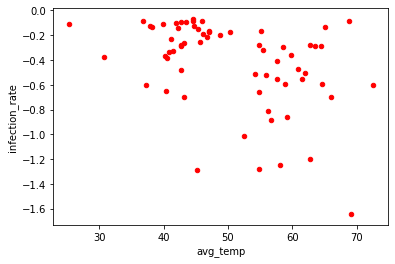

In [15]:
# Plot avg temp vs infection rate

final_data = pandas.read_csv('./covid-final-data.csv')

final_data.plot(kind='scatter',x='avg_temp',y='infection_rate',color='red')
plt.show()

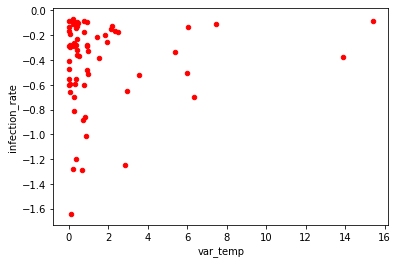

In [16]:
# Plot infection rate vs infection rate

final_data.plot(kind='scatter',x='var_temp',y='infection_rate',color='red')
plt.show()

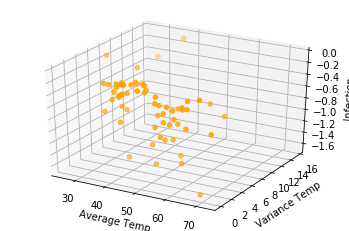

In [17]:
# Avg temp, variance temp, infection rate on 3d plot

threedee = plt.figure().gca(projection='3d')

threedee.scatter(final_data['avg_temp'], final_data['var_temp'], final_data['infection_rate'], marker="o", c='orange')
 
threedee.set_xlabel('Average Temp')
threedee.set_ylabel('Variance Temp')
threedee.set_zlabel('Infection')

plt.show()

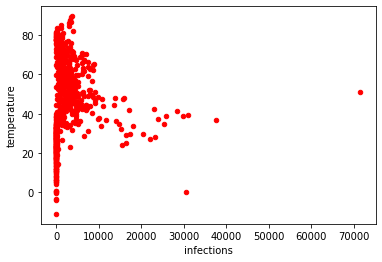

In [18]:

df.plot(kind='scatter',x='infections',y='temperature',color='red')
plt.show()

In [19]:
import tensorflow as tf
import keras
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

from keras.callbacks import LambdaCallback


Using TensorFlow backend.


In [20]:
data = pandas.read_csv('./temp-vs-infections.csv')

# print(data.values[:,:1])
print([row[0] for row in data.values])

print([row[1] for row in data.values])



[65.4, 60.4, 61.0, 53.9, 51.6, 55.0, 56.4, 59.2, 58.8, 56.3, 58.5, 57.3, 56.6, 57.6, 57.5, 59.3, 61.4, 61.3, 60.6, 61.8, 61.2, 59.9, 62.5, 65.8, 68.1, 67.3, 59.6, 59.0, 61.5, 61.6, 62.1, 61.9, 62.0, 65.3, 64.4, 61.7, 58.4, 59.4, 60.5, 62.4, 62.6, 56.8, 60.3, 62.3, 62.2, 60.7, 58.7, 59.5, 63.4, 65.9, 63.9, 62.7, 63.1, 64.3, 64.7, 67.1, 70.4, 68.8, 68.7, 68.2, 68.5, 68.0, 48.2, 50.4, 55.5, 66.2, 67.2, 42.8, 55.3, 68.4, 69.8, 67.9, 59.7, 47.0, 49.7, 50.9, 69.0, 63.8, 53.2, 43.3, 43.7, 52.0, 50.6, 42.1, 47.2, 56.1, 70.3, 64.2, 55.8, 51.2, 65.1, 65.5, 67.4, 69.3, 66.0, 66.6, 69.4, 73.1, 73.0, 64.0, 71.4, 72.7, 74.0, 72.0, 73.6, 75.7, 75.3, 70.5, 70.8, 75.6, 77.2, 63.3, 72.5, 71.2, 64.1, 67.8, 72.8, 69.6, 72.9, 66.8, 67.7, 38.9, 38.0, 46.0, 42.6, 40.8, 47.6, 36.8, 38.8, 44.3, 41.9, 41.7, 32.6, 23.7, 38.3, 43.2, 47.8, 46.1, 33.9, 28.8, 38.1, 45.6, 47.4, 47.1, 42.2, 36.7, 36.3, 48.8, 51.0, 46.7, 39.3, 40.4, 45.3, 54.7, 58.9, 51.7, 48.7, 51.1, 46.5, 42.9, 47.3, 48.5, 48.1, 58.0, 46.8, 44.6, 47.

In [21]:
temp_training = [row[0] for row in data.values]
temp_targets = [int(row[1]) for row in data.values]

In [22]:
lr = Sequential([
    Dense(1, input_shape=(1,), kernel_regularizer=keras.regularizers.l2(0.001)), # 1 layer
    Activation('linear'), # linear activation function
])

# We want to do plain vanilla stochastic gradient descent here, nothing fancy. 
# The call below removes all bells and whistles from the keras implementation of stochastic gradient
# descent. We will learn how to add back the momentum and Nesterov acceleration later.

opt = SGD(lr=0.01,momentum=0,nesterov=False)

# SGD & MSE

lr.compile(optimizer=opt, loss=keras.losses.hinge)
# 

# Again we initialize weights
lr.layers[0].set_weights([np.array([[0.01]]),np.array([0.0])])

In [23]:


lr.fit(temp_training, temp_targets, epochs=40, batch_size=10, shuffle=False)

Epoch 1/40
659/659 [==============================] - 0s 186us/step - loss: 0.1526
Epoch 2/40
659/659 [==============================] - 0s 73us/step - loss: 0.1518
Epoch 3/40
659/659 [==============================] - 0s 70us/step - loss: 0.1510
Epoch 4/40
659/659 [==============================] - 0s 70us/step - loss: 0.1510
Epoch 5/40
659/659 [==============================] - 0s 67us/step - loss: 0.1506
Epoch 6/40
659/659 [==============================] - 0s 67us/step - loss: 0.1502
Epoch 7/40
659/659 [==============================] - 0s 92us/step - loss: 0.1498
Epoch 8/40
659/659 [==============================] - 0s 114us/step - loss: 0.1494
Epoch 9/40
659/659 [==============================] - 0s 80us/step - loss: 0.1490
Epoch 10/40
659/659 [==============================] - 0s 103us/step - loss: 0.1486
Epoch 11/40
659/659 [==============================] - 0s 89us/step - loss: 0.1489
Epoch 12/40
659/659 [==============================] - 0s 88us/step - loss: 0.1479
Epoch 13/4

In [24]:
lr.predict([63])

array([[2.4913468]], dtype=float32)

In [25]:
print(final_data.values[:,4:6])

[[61.4629213483146 0.3871759907495622]
 [63.559550561797764 0.0006569992310428378]
 [47.056179775280896 2.5038522598156807]
 [30.737078651685394 13.890975786459473]
 [45.15056179775285 0.6649307364772532]
 [42.71685393258428 0.9375402554773822]
 [37.288764044943825 0.7476380536204082]
 [52.467415730337066 0.8665685003041442]
 [59.771910112359535 0.3993437467721052]
 [37.911235955056185 0.3940629770116242]
 [44.576404494382025 0.2124258874568168]
 [60.907865168539324 0.0071304271728775785]
 [40.875280898876426 5.363220682076407]
 [55.14382022471909 0.003515181163994584]
 [62.74494382022471 0.37637126854965597]
 [62.74494382022471 0.37637126854965597]
 [25.27303370786517 7.462970469752441]
 [43.20674157303372 0.2720906594667798]
 [41.17191011235956 0.4129303146985572]
 [46.8179775280899 1.4208821200261648]
 [54.12359550561799 0.9568909027785728]
 [43.20674157303372 0.2720906594667798]
 [64.538202247191 0.08051326450976233]
 [72.52696629213483 0.002542737372462171]
 [36.823595505618 15.40

In [28]:
import hdbscan
from sklearn.datasets import make_blobs

clusterer = hdbscan.RobustSingleLinkage(cut=0.125, k=7)
cluster_labels = clusterer.fit_predict(data)
hierarchy = clusterer.cluster_hierarchy_
alt_labels = hierarchy.get_clusters(0.100, 5)
hierarchy.plot()

AttributeError: 'HDBSCAN' object has no attribute 'cluster_hierarchy_'